# <div style="text-align: center">Random Forests - Kohn-Sham Mapping</div> 
 
## <div style="text-align: center">Jon Vandermause, Steven Torrisi, Simon Batzner</div> 

## <div style="text-align: center">Gaussian Potential-to-Energy </div> 

## Setup 

In [48]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from KRR_reproduce import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [49]:
# setup
ev2kcal = 1/0.043     # conversion factor
SIM_NO = 150          # total number of data points
SEED = 42
M = 10            # number of training points
GRID_SPACE = 0.6      # grid spacing for gaussian potential (see [1])

# random forest
N_ESTIMATORS = 5000   # number of treest
MAX_DEPTH = 50        # maximum depth of trees

# alternate params
# N_ESTIMATORS = 1000     
# MAX_DEPTH = 10

# path to data
os.environ['PROJDIR'] = '/Users/simonbatzner1/Desktop/Research/Research_Code/ML-electron-density'
STR_PREF = os.environ['PROJDIR'] + '/data/H2_DFT/temp_data/store/'

print("Number of estimators: {}".format(N_ESTIMATORS))
print("Maximum depth: {}".format(MAX_DEPTH))

Number of estimators: 5000
Maximum depth: 50


## Load Energies, Separation Distances and Fourier Coefficients

In [50]:
ens = []
seps = []
fours = []

for n in range(SIM_NO):
    # load separation, energy, and density
    sep = np.load(STR_PREF + 'sep_store/sep' + str(n) + '.npy')
    en = np.load(STR_PREF + 'en_store/en' + str(n) + '.npy')
    four = np.load(STR_PREF + 'four_store/four' + str(n) + '.npy')

    # format
    sep = np.reshape(sep, (1,))[0]
    en = np.reshape(en, (1,))[0]['energy']
    four = np.real(four)

    ens.append(en)
    seps.append(sep)
    fours.append(four) 
    

## Build Gaussian potentials

In [51]:
pots = []
grid_len = 5.29177 * 2

for n in range(SIM_NO):
    dist = seps[n]
    pot = pot_rep(dist, grid_len, grid_space=GRID_SPACE)
    pot = pot.flatten()
    pots.append(pot)

## Set up training and test data

In [52]:
data = pots
labels = ens

# define training and test indices
train_indices = [int(n) for n in np.round(np.linspace(0,149,M))]
test_indices = [n for n in range(150) if n not in train_indices]

if len(train_indices) != M: 
    print("Size of training set doesn't match the M specified")
    
x_train = np.array([data[n] for n in train_indices])
x_test = np.array([data[n] for n in test_indices])
y_train = np.array([labels[n] for n in train_indices])
y_test =np.array([labels[n] for n in test_indices])
x_seps_test = np.array([seps[n] for n in test_indices])

# convert to np arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(y_test.shape)

(10, 5832)
(140,)


## Train Random Forest

In [53]:
estimator = RandomForestRegressor(random_state=SEED, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
estimator.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## Results

In [54]:
# eval on training data
y_true_train, y_pred_train = y_train, estimator.predict(x_train)

# eval on test data
y_true, y_pred = y_test, estimator.predict(x_test)

# print results
print("\nNumber of estimators:\t {}".format(N_ESTIMATORS))
print("Maximum depth:\t\t {}".format(MAX_DEPTH))
print("\nPrediction on test data:\n")
print("\n\tPred   |   True\n")
print(np.c_[y_pred, y_true])
print("\n\nMAE on training data in [kcal/mol]: \t{}".format(mean_absolute_error(y_true_train, y_pred_train)*ev2kcal))
print("MAE on test data in [kcal/mol]: \t{}".format(mean_absolute_error(y_true, y_pred)*ev2kcal))


Number of estimators:	 5000
Maximum depth:		 50

Prediction on test data:


	Pred   |   True

[[-30.27139698 -29.86480944]
 [-30.27139698 -30.00126384]
 [-30.27139698 -30.13048409]
 [-30.2731352  -30.25205876]
 [-30.2731352  -30.36705412]
 [-30.2731352  -30.47510758]
 [-30.26317001 -30.57717032]
 [-30.26317001 -30.67320233]
 [-30.49710287 -30.7632198 ]
 [-30.54058835 -30.84802303]
 [-30.57169475 -30.92735568]
 [-30.58617145 -31.00192919]
 [-30.58617145 -31.07152411]
 [-30.58946233 -31.13677132]
 [-30.94402629 -31.19766036]
 [-30.94603796 -31.25422224]
 [-30.97621292 -31.35579816]
 [-30.97621292 -31.40113248]
 [-30.98042937 -31.44287327]
 [-30.98313628 -31.48142229]
 [-30.98313628 -31.51679575]
 [-31.0612148  -31.54904043]
 [-31.0624218  -31.57847976]
 [-31.16662087 -31.60506448]
 [-31.19555693 -31.62907309]
 [-31.2137302  -31.65047649]
 [-31.24344975 -31.66951141]
 [-31.25414837 -31.68621403]
 [-31.25356459 -31.70064478]
 [-31.48162235 -31.71298488]
 [-31.51106966 -31.72325065]
 [-31.

Text(0.5,0,'Distance [Angstrom]')

Text(0,0.5,'Energy [eV]')

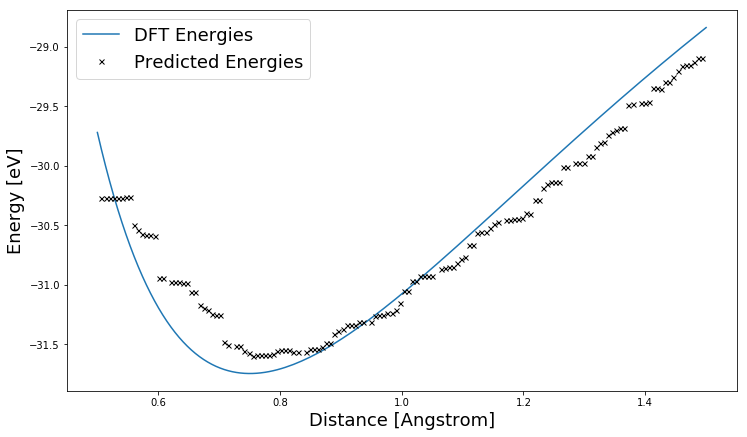

In [55]:
fig = plt.figure(figsize=(12, 7)) 
plt.plot(seps, ens, label = 'DFT Energies')
plt.plot(x_seps_test, y_pred, 'kx', MarkerSize = 5, mew = 1, label = 'Predicted Energies'); 
plt.legend(fontsize = 18)
plt.xlabel('Distance [Angstrom]', fontsize = 18)
plt.ylabel('Energy [eV]', fontsize = 18)
plt.show()

## <div style="text-align: center">Separation - to - Energy </div> 

In [56]:
# setup
SIM_NO = 150
SEED = 42
M = 10       # number of training points

# random forest params (found from hyperparameter optimization)  
N_ESTIMATORS = 5000 
MAX_DEPTH = 50

# alternate params
# N_ESTIMATORS = 1000 
# MAX_DEPTH = 20

# path to data
os.environ['PROJDIR'] = '/Users/simonbatzner1/Desktop/Research/Research_Code/ML-electron-density'
STR_PREF = os.environ['PROJDIR'] + '/data/H2_DFT/temp_data/store/'

print("Number of estimators: {}".format(N_ESTIMATORS))
print("Maximum depth: {}".format(MAX_DEPTH))

Number of estimators: 5000
Maximum depth: 50


## Load data

In [57]:
ens = []
seps = []
fours = []

for n in range(SIM_NO):
    # load separation, energy, and density
    sep = np.load(STR_PREF + 'sep_store/sep' + str(n) + '.npy')
    en = np.load(STR_PREF + 'en_store/en' + str(n) + '.npy')
    four = np.load(STR_PREF + 'four_store/four' + str(n) + '.npy')

    # format
    sep = np.reshape(sep, (1,))[0]
    en = np.reshape(en, (1,))[0]['energy']
    four = np.real(four)

    ens.append(en)
    seps.append(sep)
    fours.append(four) 

## Setup training and test data

In [58]:
data = seps
labels = ens

# define training and test indices
train_indices = [int(n) for n in np.round(np.linspace(0,149,M))]
test_indices = [n for n in range(150) if n not in train_indices]

if len(train_indices) != M: 
    print("Size of training set doesn't match the M specified")
    
x_train = np.array([data[n] for n in train_indices])
x_test = np.array([data[n] for n in test_indices])
y_train = np.array([labels[n] for n in train_indices])
y_test =np.array([labels[n] for n in test_indices])

# convert to np arrays
x_train = np.array(x_train)
x_train = x_train.reshape(-1,1)
x_test = np.array(x_test)
x_test = x_test.reshape(-1,1)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(y_test.shape)

(10, 1)
(140,)


## Train Random Forest

In [59]:
# train random forest
estimator = RandomForestRegressor(random_state=SEED, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
estimator.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## Results

In [60]:
# eval on training data
y_true_train, y_pred_train = y_train, estimator.predict(x_train)

# eval on test data
y_true, y_pred = y_test, estimator.predict(x_test)
# print results
print("\nNumber of estimators:\t {}".format(N_ESTIMATORS))
print("Maximum depth:\t\t {}".format(MAX_DEPTH))
print("\nPrediction on test data:\n")
print("\n\tPred   |   True\n")
print(np.c_[y_pred, y_true])
print("\n\nMAE on training data in [kcal/mol]: \t{}".format(mean_absolute_error(y_true_train, y_pred_train)*ev2kcal))
print("MAE on test data in [kcal/mol]: \t{}".format(mean_absolute_error(y_true, y_pred)*ev2kcal))


Number of estimators:	 5000
Maximum depth:		 50

Prediction on test data:


	Pred   |   True

[[-30.31630128 -29.86480944]
 [-30.31630128 -30.00126384]
 [-30.31630128 -30.13048409]
 [-30.31630128 -30.25205876]
 [-30.31630128 -30.36705412]
 [-30.31630128 -30.47510758]
 [-30.31630128 -30.57717032]
 [-30.31630128 -30.67320233]
 [-30.96541061 -30.7632198 ]
 [-30.96541061 -30.84802303]
 [-30.96541061 -30.92735568]
 [-30.96541061 -31.00192919]
 [-30.96541061 -31.07152411]
 [-30.96541061 -31.13677132]
 [-30.96541061 -31.19766036]
 [-30.96541061 -31.25422224]
 [-31.28446053 -31.35579816]
 [-31.28446053 -31.40113248]
 [-31.28446053 -31.44287327]
 [-31.28446053 -31.48142229]
 [-31.28446053 -31.51679575]
 [-31.28446053 -31.54904043]
 [-31.28446053 -31.57847976]
 [-31.28446053 -31.60506448]
 [-31.57867833 -31.62907309]
 [-31.57867833 -31.65047649]
 [-31.57867833 -31.66951141]
 [-31.57867833 -31.68621403]
 [-31.57867833 -31.70064478]
 [-31.57867833 -31.71298488]
 [-31.57867833 -31.72325065]
 [-31.

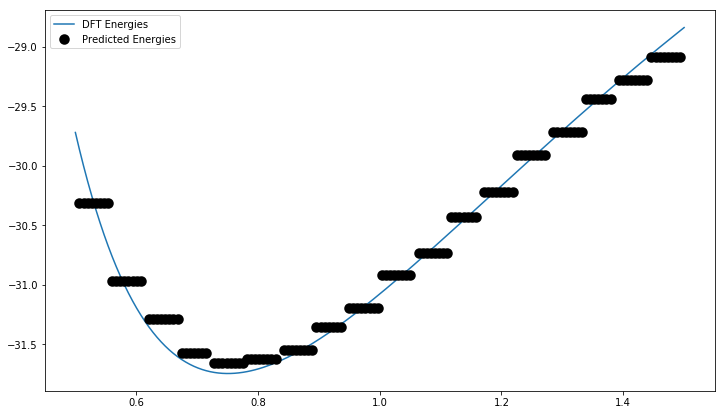

In [61]:
fig = plt.figure(figsize=(12, 7)) 
plt.plot(seps, ens, label = 'DFT Energies')
plt.plot(x_seps_test, y_pred, 'k.', MarkerSize = 15, mew = 3, label = 'Predicted Energies'); 
plt.legend(fontsize = 18)
plt.xlabel('Distance [Angstrom]', fontsize = 18)
plt.ylabel('Energy [eV]', fontsize = 18)
plt.show()

For comparison, from [1]: "The MAE that is introduced by the PBE approximation on the H2 data set is 2.3 kcal/mol (compared to exact CI calculations)"

[1] Brockherde et al. Bypassing the Kohn-Sham equations with machine learning. Nature Communications 8, 872 (2017)